# Predictor for Drug-induced Liver Injury (DILI)

## Training datasets: 

1. **FDA Drug Induced Liver Injury Rank (DILIrank) Dataset** , https://www.fda.gov/science-research/liver-toxicity-knowledge-base-ltkb/drug-induced-liver-injury-rank-dilirank-dataset.

2. **DL-DILI-Liew** and **DL-DILI-combined** datasets from DL-DILI project http://www.pkumdl.cn:8080/DILIserver/DILIhome.php

3. **Chen Dataset** (LTKB Benchmark Dataset, from Chen M. et al. (2013) *Quantitative Structure-Activity Relationship Models for Predicting Drug-Induced Liver Injury Based on FDA-Approved Drug Labeling Annotation and Using a Large Collection of Drugs*, https://doi.org/10.1093/toxsci/kft189) 

## External validation dataset

**Greene Dataset** (External validation Dataset, from Chen M. et al. (2013) *Quantitative Structure-Activity Relationship Models for Predicting Drug-Induced Liver Injury Based on FDA-Approved Drug Labeling Annotation and Using a Large Collection of Drugs*, https://doi.org/10.1093/toxsci/kft189)







## ML Features *(generated from SMILES)*: 

1.   Morgan Fingerprints
2.   Physico-chemical properties (PaDEL descriptors)


## TO DO:
1. Check for chemical bias caused by structural similarity between validation and training datasets, and remove bias with AVE bias script or using Tanimoto Similarity check
2. Hyperparameter tuning and optimisation for predictors

## Instalation and Loading of libraries

In [4]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install padelpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install xlrd==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole

In [10]:
# Support for RDKit-ROMol in Pandas
from rdkit.Chem import PandasTools

In [14]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score


In [15]:
from sklearn._config import set_config
set_config(print_changed_only=False)

In [16]:
from pycm import ConfusionMatrix

In [17]:
from padelpy import padeldescriptor

In [18]:
# Function to prepare Morgan Fingerprint from SMILES
def fp_bit(smiles):
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    return np.array(morgan_fp, dtype=np.int32)

## Datasets preparation

### Load dataset 1 (FDA Rank)

In [19]:
fda = pd.read_excel('Input/FDA_DILIrank.xlsx', header=1)

In [20]:
fda

,LTKBID,Compound Name,Severity Class,Label Section,vDILIConcern,Version
0,LT00003,mercaptopurine,8,Warnings and precautions,vMost-DILI-Concern,1
1,LT00004,acetaminophen,5,Warnings and precautions,vMost-DILI-Concern,2
2,LT00006,azathioprine,5,Warnings and precautions,vMost-DILI-Concern,1
3,LT00009,chlorpheniramine,0,No match,vNo-DILI-Concern,2
4,LT00011,clofibrate,3,Warnings and precautions,vLess-DILI-Concern,1
...,...,...,...,...,...,...
1031,LT02449,sitaxsentan,8,Withdrawn,vMost-DILI-Concern,2
1032,LT02907,laronidase,4,Adverse reactions,Ambiguous DILI-concern,2
1033,LT02909,dexmethylphenidate,7,Adverse reactions,vLess-DILI-Concern,2
1034,LT02913,hyaluronidase recombinant human,0,No match,vNo-DILI-Concern,2


In [21]:
fda['Severity Class'].value_counts()

0    338
3    309
8    159
5     62
7     60
4     53
2     46
6      5
1      4
Name: Severity Class, dtype: int64

In [22]:
fda[fda.vDILIConcern == 'vMost-DILI-Concern']

,LTKBID,Compound Name,Severity Class,Label Section,vDILIConcern,Version
0,LT00003,mercaptopurine,8,Warnings and precautions,vMost-DILI-Concern,1
1,LT00004,acetaminophen,5,Warnings and precautions,vMost-DILI-Concern,2
2,LT00006,azathioprine,5,Warnings and precautions,vMost-DILI-Concern,1
9,LT00020,gemfibrozil,4,Warnings and precautions,vMost-DILI-Concern,1
10,LT00022,indomethacin,8,Warnings and precautions,vMost-DILI-Concern,1
...,...,...,...,...,...,...
997,LT02121,nandrolone decanoate,7,Warnings and precautions,vMost-DILI-Concern,2
1004,LT02204,lapatinib,8,Box warning,vMost-DILI-Concern,1
1006,LT02213,alaproclate,8,Withdrawn,vMost-DILI-Concern,1
1007,LT02216,orlistat,8,Warnings and precautions,vMost-DILI-Concern,1


In [23]:
fda[fda.vDILIConcern.str.contains('No-DILI', case=False)]

,LTKBID,Compound Name,Severity Class,Label Section,vDILIConcern,Version
3,LT00009,chlorpheniramine,0,No match,vNo-DILI-Concern,2
6,LT00015,dopamine,0,No match,vNo-DILI-Concern,2
12,LT00024,mannitol,0,No match,vNo-DILI-Concern,1
28,LT00054,aminohippurate,0,No match,vNo-DILI-Concern,2
40,LT00074,dimercaprol,0,No match,vNo-DILI-Concern,2
...,...,...,...,...,...,...
1024,LT02385,agalsidase beta,0,No match,vNo-DILI-Concern,2
1025,LT02404,gadolinium ethoxybenzyl DTPA,0,No match,vNo-DILI-Concern,2
1029,LT02437,Levoleucovorin,0,No match,vNo-DILI-Concern,2
1030,LT02442,levomefolate calcium,0,No match,vNo-DILI-Concern,2


### Dataset 2 (DL-DILI-Liew)

In [24]:
liew_train = pd.read_csv('Input/DL-DILI-Liew_train_dataset.csv')
liew_train

,smiles,label
0,CC(Cl)(Cl)Cl,1
1,C(C(Cl)Cl)Cl,1
2,CN(C)N,1
3,C(C=CCl)Cl,1
4,Cc1c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-],1
...,...,...
1060,CN(C)CCc1c[nH]c2c1cc(cc2)CC3COC(=O)N3,0
1061,Cc1ccc(cc1)c2c(n3cc(ccc3n2)C)CC(=O)N(C)C,1
1062,c1ccc2c(c1)c(no2)CS(=O)(=O)N,1
1063,CN1CCN(CC1)C(=O)OC2c3c(nccn3)C(=O)N2c4ccc(cn4)Cl,0


In [25]:
liew_train.label.value_counts()

1    648
0    417
Name: label, dtype: int64

In [26]:
liew_test = pd.read_csv('Input/DL-DILI-Liew_test_dataset.csv')
liew_test

,smiles,label
0,c1ccc2c(c1)cccc2N=C=S,1
1,CCOCCO,1
2,CCCC(=O)Nc1ccc(c(c1)C(=O)C)OCC(CNC(C)C)O,1
3,CC1(C(N2C(S1)C(C2=O)N=CN3CCCCCC3)C(=O)O)C,1
4,c1cc(c(c2c1NC3=NC(=O)CN3C2)Cl)Cl,0
...,...,...
114,CC12CCC3C(C1CCC2O)CCC45C3(CC(=C(C4O5)O)C#N)C,0
115,CN1C2CCC1CC(C2)OC(=O)c3c[nH]c4c3cccc4,1
116,CN1CCc2cc(c3cc2C1Cc4ccc(cc4)Oc5c6c(cc(c5O)OC)C...,0
117,C(=O)(N)N,0


### Load dataset 3 (Chen)

In [27]:
chen0 = pd.read_excel('Input/Chen_datasets.xls', sheet_name=0)
chen1 = pd.read_excel('Input/Chen_datasets.xls', sheet_name=1)

In [28]:
chen_original = pd.concat([chen0, chen1], axis=0)

In [29]:
chen_original

,PubChem,CompoundName,Drug label-based annotation,QSAR Prediction
0,3474,glafenine,Most DILI-concern,NaN
1,2478,busulfan,Most DILI-concern,NaN
2,2520,verapamil,Most DILI-concern,NaN
3,2662,celecoxib,Most DILI-concern,NaN
4,2898,cyclofenil,Most DILI-concern,NaN
...,...,...,...,...
185,11033,sulfacarbamide,Most DILI-concern,0.0
186,6179,mebanazine,Most DILI-concern,0.0
187,71467,phenoxypropazine,Most DILI-concern,0.0
188,114965,tetrabamate,Most DILI-concern,0.0


In [30]:
chen_original = chen_original.drop('QSAR Prediction', axis=1)
chen_original.drop_duplicates('PubChem')

,PubChem,CompoundName,Drug label-based annotation
0,3474,glafenine,Most DILI-concern
1,2478,busulfan,Most DILI-concern
2,2520,verapamil,Most DILI-concern
3,2662,celecoxib,Most DILI-concern
4,2898,cyclofenil,Most DILI-concern
...,...,...,...
185,11033,sulfacarbamide,Most DILI-concern
186,6179,mebanazine,Most DILI-concern
187,71467,phenoxypropazine,Most DILI-concern
188,114965,tetrabamate,Most DILI-concern


In [31]:
# fetching SMILES from PubChem
chen_original.PubChem.to_csv('Output/chen_list.csv', index=None, header=None)

In [32]:
chen_pubchem = pd.read_csv('Input/chen_pubchem.csv')
chen_pubchem

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,inchikey,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,247,Betaine,betaine|107-43-7|glycine betaine|oxyneurine|ly...,117.15,C5H11NO2,40.1,87.6,0.5,8,0,...,KWIUHFFTVRNATP-UHFFFAOYSA-N,2-(trimethylazaniumyl)acetate,Betaine,Biological Test Results|Biomolecular Interacti...,14,192|248|608|1033|1195|1549|1552|1637|1648|7104...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
1,298,"2,2-dichloro-N-[1,3-dihydroxy-1-(4-nitrophenyl...","2,2-dichloro-N-[1,3-dihydroxy-1-(4-nitrophenyl...",323.13,C11H12Cl2N2O5,115.0,342.0,1.1,20,3,...,WIIZWVCIJKGZOK-UHFFFAOYSA-N,"2,2-dichloro-N-[1,3-dihydroxy-1-(4-nitrophenyl...",NaN,Biological Test Results|Chemical and Physical ...,8,155|157|175|248|256|328|485|631|731|757|758|75...,20050325,001Chemical|AAA Chemistry|abcr GmbH|ABI Chem|A...,Chemical Vendors|Curation Efforts|Governmental...,NaN
2,338,Salicylic acid,salicylic acid|2-Hydroxybenzoic acid|69-72-7|o...,138.12,C7H6O3,57.5,133.0,2.3,10,2,...,YGSDEFSMJLZEOE-UHFFFAOYSA-N,2-hydroxybenzoic acid,Salicylic Acid,Biological Test Results|Biomolecular Interacti...,14,155|157|161|165|167|175|179|248|485|568|583|59...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,453,Hexitol,"Hexitol|hexane-1,2,3,4,5,6-hexaol|hexane-1,2,3...",182.17,C6H14O6,121.0,105.0,-3.1,12,6,...,FBPFZTCFMRRESA-UHFFFAOYSA-N,"hexane-1,2,3,4,5,6-hexol",NaN,Biological Test Results|Classification|Literat...,6,155|157|161|165|167|175|188|200|208|214|220|24...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
4,679,Dimethyl sulfoxide,dimethyl sulfoxide|DMSO|67-68-5|Methyl sulfoxi...,78.14,C2H6OS,36.3,29.0,-0.6,4,0,...,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,methylsulfinylmethane,Dimethyl Sulfoxide,Biological Test Results|Biomolecular Interacti...,14,179|180|186|192|194|196|206|212|220|222|226|24...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16133850,Forteo,Parathar|Forteo|UNII-10T9CSU89I|10T9CSU89I|Par...,4118.00,C181H291N55O51S2,1800.0,9740.0,-18.7,289,60,...,OGBMKVWORPGQRR-UMXFMPSGSA-N,(4S)-4-[[(2S)-2-[[(2S)-2-[[(2S)-4-amino-2-[[(2...,Teriparatide,Classification|Drug and Medication Information...,9,NaN,20070704,Adooq BioScience|AKos Consulting & Solutions|A...,Chemical Vendors|Curation Efforts|Governmental...,NaN
373,23663956,Divalproex sodium,DIVALPROEX SODIUM|76584-70-8|Valproate semisod...,310.40,C16H31NaO4,77.4,192.0,NaN,21,1,...,MSRILKIQRXUYCT-UHFFFAOYSA-M,sodium;2-propylpentanoate;2-propylpentanoic acid,Valproic Acid,Biological Test Results|Biomolecular Interacti...,11,588209|588210|1347080|1409605|1474166|1474167|...,20080205,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
374,23673837,Docusate sodium,Docusate sodium|577-11-7|Dioctyl sodium sulfos...,444.60,C20H37NaO7S,118.0,546.0,NaN,29,0,...,APSBXTVYXVQYAB-UHFFFAOYSA-M,"sodium;1,4-bis(2-ethylhexoxy)-1,4-dioxobutane-...",Dioctyl Sulfosuccinic Acid,Biological Test Results|Biomolecular Interacti...,14,1195|1469|1479|588513|588514|588515|588516|588...,20080205,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
375,44152182,Ecallantide,Ecallantide|Kalbitor|FOV2302|DX-88|GTPL6955|DT...,7054.00,C305H442N88O91S8,3120.0,18500.0,-27.9,492,100,...,VBGWSQKGUZHFPS-VGMMZINCSA-N,"(2S)-2-[[(2S)-2-[[(2S,3S)-2-[[(1R,2aS,4S,5aS,8...",NaN,Chemical and Physical Properties|Classificatio...,10,NaN,20090820,Drug Induced Liver Injury Rank (DILIrank) Data...,Curation Efforts|Governmental Organizations|Le...,NaN


In [33]:
chen_pubchem.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'inchikey', 'iupacname', 'meshheadings', 'annothits',
       'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [34]:
chen_pubchem = chen_pubchem.rename(columns={'cid':'PubChem', 'cmpdname':'PubChem_name', 'isosmiles':'Smiles'})

In [35]:
chen = chen_original.merge(chen_pubchem, on='PubChem', how='inner')

In [36]:
chen.columns

Index(['PubChem', 'CompoundName', 'Drug label-based annotation',
       'PubChem_name', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'Smiles', 'inchikey', 'iupacname', 'meshheadings', 'annothits',
       'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [37]:
chen['DILI_label'] = chen['Drug label-based annotation'].map({'Most DILI-concern':1,'no DILI-concern':0 })

In [38]:
#condlist = [(chen['Drug label-based annotation'] == 'Most DILI-concern'), \
#            (chen['Drug label-based annotation'] == 'no DILI-concern')]
#choicelist = [1, 0]
#chen['DILI_label'] = np.select(condlist, choicelist, default=np.nan)

In [39]:
chen.isna().sum()

PubChem                          0
CompoundName                     0
Drug label-based annotation      0
PubChem_name                     0
cmpdsynonym                      2
mw                               0
mf                               0
polararea                        0
complexity                       0
xlogp                           23
heavycnt                         0
hbonddonor                       0
hbondacc                         0
rotbonds                         0
inchi                            0
Smiles                           0
inchikey                         0
iupacname                        0
meshheadings                   116
annothits                        0
annothitcnt                      0
aids                            23
cidcdate                         0
sidsrcname                       0
depcatg                          0
annotation                     327
DILI_label                       0
dtype: int64

In [40]:
chen.groupby('DILI_label').count()

,PubChem,CompoundName,Drug label-based annotation,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,xlogp,...,inchikey,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
DILI_label,,,,,,,,,,,,,,,,,,,,,
0,209,209,209,209,207,209,209,209,209,191,...,209,209,153,209,209,193,209,209,209,27
1,168,168,168,168,168,168,168,168,168,163,...,168,168,108,168,168,161,168,168,168,23


In [41]:
chen

,PubChem,CompoundName,Drug label-based annotation,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,xlogp,...,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label
0,3474,glafenine,Most DILI-concern,Glafenine,glafenine|3820-67-5|Glaphenine|Glafenin|Glycer...,372.80,C19H17ClN2O4,91.7,467.0,3.5,...,"2,3-dihydroxypropyl 2-[(7-chloroquinolin-4-yl)...",Glafenine,Biological Test Results|Biomolecular Interacti...,9,700|875|880|881|884|885|887|889|892|893|894|90...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
1,2478,busulfan,Most DILI-concern,Busulfan,busulfan|55-98-1|Myleran|Busulphan|Sulphabutin...,246.30,C6H14O6S2,104.0,294.0,-0.5,...,4-methylsulfonyloxybutyl methanesulfonate,Busulfan,Biological Test Results|Biomolecular Interacti...,13,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
2,2520,verapamil,Most DILI-concern,Verapamil,VERAPAMIL|52-53-9|Iproveratril|Vasolan|Dilacor...,454.60,C27H38N2O4,64.0,606.0,3.8,...,"2-(3,4-dimethoxyphenyl)-5-[2-(3,4-dimethoxyphe...",Verapamil,Biological Test Results|Biomolecular Interacti...,13,880|894|1030|1332|1379|1454|1457|1458|1460|146...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1
3,2662,celecoxib,Most DILI-concern,Celecoxib,celecoxib|169590-42-5|Celebrex|Celebra|Onsenal...,381.40,C17H14F3N3O2S,86.4,577.0,3.4,...,4-[5-(4-methylphenyl)-3-(trifluoromethyl)pyraz...,Celecoxib,Biological Test Results|Biomolecular Interacti...,13,1|5|7|9|19|21|23|25|29|31|33|35|37|39|41|43|45...,20050325,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1
4,2898,cyclofenil,Most DILI-concern,Cyclofenil,cyclofenil|2624-43-3|Ondogyne|Cyclofenyl|Cyclo...,364.40,C23H24O4,52.6,503.0,5.5,...,[4-[(4-acetyloxyphenyl)-cyclohexylidenemethyl]...,Cyclofenil,Biological Test Results|Biomolecular Interacti...,11,1195|1469|1471|1477|1479|1490|1688|1766|1768|2...,20050325,001Chemical|3WAY PHARM INC|4C Pharma Scientifi...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,11033,sulfacarbamide,Most DILI-concern,Sulfacarbamide,Sulfacarbamide|547-44-4|SULFANILYLUREA|Sulfaur...,215.23,C7H9N3O3S,124.0,301.0,-1.5,...,(4-aminophenyl)sulfonylurea,NaN,Biological Test Results|Biomolecular Interacti...,9,155|157|161|165|167|175|1471|1490|1688|1766|17...,20050326,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
373,6179,mebanazine,Most DILI-concern,Mebanazine,Mebanazine|65-64-5|Actamol|1-(1-PHENYLETHYL)HY...,136.19,C8H12N2,38.0,87.3,0.9,...,1-phenylethylhydrazine,NaN,Biological Test Results|Biomolecular Interacti...,10,625276|625293|1079931|1079932|1079933|1079934|...,20050326,3WAY PHARM INC|A2B Chem|AA BLOCKS|AAA Chemistr...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
374,71467,phenoxypropazine,Most DILI-concern,Phenoxypropazine,Phenoxypropazine|Fenoxypropazine|3818-37-9|1-p...,166.22,C9H14N2O,47.3,113.0,1.1,...,1-phenoxypropan-2-ylhydrazine,NaN,Biological Test Results|Biomolecular Interacti...,9,625276|625293|651631|651632|651633|651634|6516...,20050808,3WAY PHARM INC|A2B Chem|AA BLOCKS|AAA Chemistr...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
375,114965,tetrabamate,Most DILI-concern,Atrium (drug),60763-47-5|Atrium (drug)|Atrium 300|difebarbam...,1216.30,C60H81N9O18,384.0,1800.0,NaN,...,[1-butoxy-3-[3-(3-butoxy-2-carbamoyloxypropyl)...,NaN,Classification|Literature|Names and Identifier...,4,NaN,20050808,AAA Chemistry|ABI Chem|ChemIDplus|ChemSpider|C...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1


In [42]:
chen.to_csv('Input/chen.csv', index=None)

 ### Additional validation dataset of Greene et. al. (from Chen publication)

In [43]:
chen_greene = pd.read_excel('Input/Chen_datasets.xls', sheet_name=2)
chen_greene

,Pubchem,CompoundName,Greene et al.annotation,QSAR Prediction
0,4723,pemoline,HH,1
1,2333,benzbromarone,HH,1
2,4495,nimesulide,HH,1
3,35935,pirprofen,HH,1
4,39941,benoxaprofen,HH,1
...,...,...,...,...
323,447458,ragaglitazar,NE,1
324,16682734,bismuth subsalicylate,NE,1
325,54677972,isoxicam,NE,1
326,892,inositol,NE,0


In [44]:
chen_greene['Greene et al.annotation'].value_counts()

HH    214
NE    114
Name: Greene et al.annotation, dtype: int64

In [45]:
# fetching SMILES from PubChem
chen_greene.Pubchem.to_csv('Output/greene_list.csv', index=None, header=None)

In [46]:
greene_pubchem = pd.read_csv('Input/greene_pubchem.csv')
greene_pubchem

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,inchikey,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,187,Acetylcholine,acetylcholine|Choline acetate|O-Acetylcholine|...,146.210,C7H16NO2+,26.3,115.0,0.2,10,0,...,OIPILFWXSMYKGL-UHFFFAOYSA-N,2-acetyloxyethyl(trimethyl)azanium,Acetylcholine,Biological Test Results|Biomolecular Interacti...,10,423|880|1030|1457|1458|1460|1463|1468|1469|147...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."
1,247,Betaine,betaine|107-43-7|glycine betaine|oxyneurine|ly...,117.150,C5H11NO2,40.1,87.6,0.5,8,0,...,KWIUHFFTVRNATP-UHFFFAOYSA-N,2-(trimethylazaniumyl)acetate,Betaine,Biological Test Results|Biomolecular Interacti...,14,192|248|608|1033|1195|1549|1552|1637|1648|7104...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
2,564,Aminocaproic acid,6-aminohexanoic acid|6-Aminocaproic acid|amino...,131.170,C6H13NO2,63.3,83.1,-3.0,9,2,...,SLXKOJJOQWFEFD-UHFFFAOYSA-N,6-aminohexanoic acid,Aminocaproic Acid,Biological Test Results|Biomolecular Interacti...,13,155|157|161|165|167|175|179|256|357|410|411|42...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,681,Dopamine,"dopamine|4-(2-Aminoethyl)benzene-1,2-diol|3-Hy...",153.180,C8H11NO2,66.5,119.0,-1.0,11,3,...,VYFYYTLLBUKUHU-UHFFFAOYSA-N,"4-(2-aminoethyl)benzene-1,2-diol",Dopamine,Biological Test Results|Biomolecular Interacti...,13,200|256|357|410|411|444|445|446|447|448|450|45...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
4,727,Lindane,"lindane|beta-HCH|gamma-HCH|1,2,3,4,5,6-Hexachl...",290.800,C6H6Cl6,0.0,104.0,3.8,12,0,...,JLYXXMFPNIAWKQ-UHFFFAOYSA-N,"1,2,3,4,5,6-hexachlorocyclohexane",NaN,Agrochemical Information|Biological Test Resul...,15,192|200|212|220|222|226|248|256|302|330|875|88...,20040916,3B Scientific (Wuhan) Corp|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,54675785,Methacycline,methacycline|Metacycline|914-00-1|Rondomycin|M...,442.400,C22H22N2O8,182.0,998.0,0.3,32,6,...,XIYOPDCBBDCGOE-IWVLMIASSA-N,"(4S,4aR,5S,5aR,12aR)-4-(dimethylamino)-1,5,10,...",Methacycline,Biological Test Results|Biomolecular Interacti...,12,1195|1332|71156|311524|504419|625294|686977|10...,20111226,3WAY PHARM INC|A2B Chem|AA BLOCKS|Aaron Chemic...,Chemical Vendors|Curation Efforts|Governmental...,NaN
312,54677972,Isoxicam,isoxicam|34552-84-6|Maxicam|Isoxicamo|Isoxicam...,335.340,C14H13N3O5S,121.0,627.0,3.0,23,2,...,YYUAYBYLJSNDCX-UHFFFAOYSA-N,"4-hydroxy-2-methyl-N-(5-methyl-1,2-oxazol-3-yl...",NaN,Biological Test Results|Biomolecular Interacti...,10,357|361|364|368|371|373|374|375|410|411|422|42...,20111226,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
313,54678501,"3,4-Dihydroxy-5-[(S)-1,2-dihydroxyethyl]furan-...","(Vitamin C)|L(+)-Ascorbicacid|3,4-Dihydroxy-5-...",176.120,C6H8O6,107.0,232.0,-1.6,12,4,...,CIWBSHSKHKDKBQ-SZSCBOSDSA-N,"2-[(1S)-1,2-dihydroxyethyl]-3,4-dihydroxy-2H-f...",NaN,Drug and Medication Information|Literature|Pat...,3,NaN,20111226,3B Scientific (Wuhan) Corp|ABI Chem|AHH Chemic...,Chemical Vendors|Curation Efforts|Governmental...,NaN
314,54680690,Demeclocycline,demeclocycline|Demethylchlortetracycline|DMCT|...,464.900,C21H21ClN2O8,182.0,961.0,0.7,32,6,...,GUXHBMASAHGULD-SEYHBJAFSA-N,"(4S,4aS,5aS,6S,12aR)-7-chloro-4-(dimethylamino...",Demeclocycline,Biological Test Results|Biomolecular Interacti...,13,1195|1332|2660|2666|2667|2668|409958|409960|44...,20111226,3B Scientific (Wuhan) Corp|3WAY PHARM INC|A&J ...,Chemical Vendors|Curation Efforts|Governmental...,NaN


In [47]:
greene_pubchem.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'inchikey', 'iupacname', 'meshheadings', 'annothits',
       'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [48]:
greene_pubchem = greene_pubchem.rename(columns={'cid':'Pubchem', 'cmpdname':'PubChem_name', 'isosmiles':'Smiles'})

In [49]:
greene = chen_greene.merge(greene_pubchem, on='Pubchem', how='inner')
greene.columns

Index(['Pubchem', 'CompoundName', 'Greene et al.annotation', 'QSAR Prediction',
       'PubChem_name', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'Smiles', 'inchikey', 'iupacname', 'meshheadings', 'annothits',
       'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [50]:
greene['DILI_label'] = greene['Greene et al.annotation'].map({'HH':1,'NE':0 })
greene.isna().sum()

Pubchem                      0
CompoundName                 0
Greene et al.annotation      0
QSAR Prediction              0
PubChem_name                 0
cmpdsynonym                  3
mw                           0
mf                           0
polararea                    0
complexity                   0
xlogp                       18
heavycnt                     0
hbonddonor                   0
hbondacc                     0
rotbonds                     0
inchi                        0
Smiles                       0
inchikey                     0
iupacname                    1
meshheadings                64
annothits                    0
annothitcnt                  0
aids                        18
cidcdate                     0
sidsrcname                   0
depcatg                      0
annotation                 280
DILI_label                   0
dtype: int64

In [51]:
greene

,Pubchem,CompoundName,Greene et al.annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label
0,4723,pemoline,HH,1,Pemoline,pemoline|Phenylisohydantoin|Phenoxazole|Azokso...,176.17,C9H8N2O2,64.7,244.0,...,"2-amino-5-phenyl-1,3-oxazol-4-one",Pemoline,Biological Test Results|Biomolecular Interacti...,13,192|248|485|631|731|781|782|880|950|951|952|10...,20050325,3B Scientific (Wuhan) Corp|AAA Chemistry|ABI C...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
1,2333,benzbromarone,HH,1,Benzbromarone,benzbromarone|3562-84-3|Desuric|Benzbromaron|U...,424.10,C17H12Br2O3,50.4,405.0,...,"(3,5-dibromo-4-hydroxyphenyl)-(2-ethyl-1-benzo...",Benzbromarone,Biological Test Results|Biomolecular Interacti...,12,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
2,4495,nimesulide,HH,1,Nimesulide,nimesulide|51803-78-2|N-(4-Nitro-2-phenoxyphen...,308.31,C13H12N2O5S,110.0,450.0,...,N-(4-nitro-2-phenoxyphenyl)methanesulfonamide,NaN,Biological Test Results|Biomolecular Interacti...,12,357|361|364|368|371|373|374|375|377|410|411|42...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
3,35935,pirprofen,HH,1,Pirprofen,Pirprofen|Rengasil|31793-07-4|SU 21524|SU-2152...,251.71,C13H14ClNO2,40.5,311.0,...,"2-[3-chloro-4-(2,5-dihydropyrrol-1-yl)phenyl]p...",NaN,Biological Test Results|Biomolecular Interacti...,10,1195|243647|588209|588210|588211|588212|588213...,20050808,3WAY PHARM INC|ABI Chem|Aurora Fine Chemicals ...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
4,39941,benoxaprofen,HH,1,Benoxaprofen,Benoxaprofen|51234-28-7|Oraflex|Uniprofen|Coxi...,301.72,C16H12ClNO3,63.3,384.0,...,"2-[2-(4-chlorophenyl)-1,3-benzoxazol-5-yl]prop...",NaN,Biological Test Results|Biomolecular Interacti...,11,179|330|1195|173208|177359|178648|189984|18998...,20050326,001Chemical|3A SpeedChemical Inc|3WAY PHARM IN...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,447458,ragaglitazar,NE,1,Ragaglitazar,Ragaglitazar|(2S)-2-ETHOXY-3-{4-[2-(10H-PHENOX...,419.50,C25H25NO5,68.2,542.0,...,(2S)-2-ethoxy-3-[4-(2-phenoxazin-10-ylethoxy)p...,NaN,Biological Test Results|Biomolecular Interacti...,6,1811|25979|25980|27154|27155|27882|28334|28335...,20050624,AbaChemScene|ABI Chem|Achemtek|BindingDB|Chemb...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0
312,16682734,bismuth subsalicylate,NE,1,Bismuth subsalicylate,BISMUTH SUBSALICYLATE|14882-18-9|Bismuth oxysa...,363.10,C7H6BiO4,36.5,173.0,...,NaN,NaN,Biological Test Results|Biomolecular Interacti...,12,568|583|598|602|606|618|620|629|630|633|639|64...,20070823,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0
313,54677972,isoxicam,NE,1,Isoxicam,isoxicam|34552-84-6|Maxicam|Isoxicamo|Isoxicam...,335.34,C14H13N3O5S,121.0,627.0,...,"4-hydroxy-2-methyl-N-(5-methyl-1,2-oxazol-3-yl...",NaN,Biological Test Results|Biomolecular Interacti...,10,357|361|364|368|371|373|374|375|410|411|422|42...,20111226,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0
314,892,inositol,NE,0,Inositol,inositol|myo-inositol|Scyllo-inositol|Muco-Ino...,180.16,C6H12O6,121.0,104.0,...,"cyclohexane-1,2,3,4,5,6-hexol",NaN,Biological Test Results|Biomolecular Interacti...,13,1|3|5|7|9|13|19|23|25|29|31|33|35|37|39|41|43|...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",0


In [52]:
greene.groupby('DILI_label').count()

,Pubchem,CompoundName,Greene et al.annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,inchikey,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
DILI_label,,,,,,,,,,,,,,,,,,,,,
0,112,112,112,112,112,110,112,112,112,112,...,112,111,89,112,112,105,112,112,112,10
1,204,204,204,204,204,203,204,204,204,204,...,204,204,163,204,204,193,204,204,204,26


In [53]:
greene

,Pubchem,CompoundName,Greene et al.annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label
0,4723,pemoline,HH,1,Pemoline,pemoline|Phenylisohydantoin|Phenoxazole|Azokso...,176.17,C9H8N2O2,64.7,244.0,...,"2-amino-5-phenyl-1,3-oxazol-4-one",Pemoline,Biological Test Results|Biomolecular Interacti...,13,192|248|485|631|731|781|782|880|950|951|952|10...,20050325,3B Scientific (Wuhan) Corp|AAA Chemistry|ABI C...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
1,2333,benzbromarone,HH,1,Benzbromarone,benzbromarone|3562-84-3|Desuric|Benzbromaron|U...,424.10,C17H12Br2O3,50.4,405.0,...,"(3,5-dibromo-4-hydroxyphenyl)-(2-ethyl-1-benzo...",Benzbromarone,Biological Test Results|Biomolecular Interacti...,12,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
2,4495,nimesulide,HH,1,Nimesulide,nimesulide|51803-78-2|N-(4-Nitro-2-phenoxyphen...,308.31,C13H12N2O5S,110.0,450.0,...,N-(4-nitro-2-phenoxyphenyl)methanesulfonamide,NaN,Biological Test Results|Biomolecular Interacti...,12,357|361|364|368|371|373|374|375|377|410|411|42...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
3,35935,pirprofen,HH,1,Pirprofen,Pirprofen|Rengasil|31793-07-4|SU 21524|SU-2152...,251.71,C13H14ClNO2,40.5,311.0,...,"2-[3-chloro-4-(2,5-dihydropyrrol-1-yl)phenyl]p...",NaN,Biological Test Results|Biomolecular Interacti...,10,1195|243647|588209|588210|588211|588212|588213...,20050808,3WAY PHARM INC|ABI Chem|Aurora Fine Chemicals ...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
4,39941,benoxaprofen,HH,1,Benoxaprofen,Benoxaprofen|51234-28-7|Oraflex|Uniprofen|Coxi...,301.72,C16H12ClNO3,63.3,384.0,...,"2-[2-(4-chlorophenyl)-1,3-benzoxazol-5-yl]prop...",NaN,Biological Test Results|Biomolecular Interacti...,11,179|330|1195|173208|177359|178648|189984|18998...,20050326,001Chemical|3A SpeedChemical Inc|3WAY PHARM IN...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,447458,ragaglitazar,NE,1,Ragaglitazar,Ragaglitazar|(2S)-2-ETHOXY-3-{4-[2-(10H-PHENOX...,419.50,C25H25NO5,68.2,542.0,...,(2S)-2-ethoxy-3-[4-(2-phenoxazin-10-ylethoxy)p...,NaN,Biological Test Results|Biomolecular Interacti...,6,1811|25979|25980|27154|27155|27882|28334|28335...,20050624,AbaChemScene|ABI Chem|Achemtek|BindingDB|Chemb...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0
312,16682734,bismuth subsalicylate,NE,1,Bismuth subsalicylate,BISMUTH SUBSALICYLATE|14882-18-9|Bismuth oxysa...,363.10,C7H6BiO4,36.5,173.0,...,NaN,NaN,Biological Test Results|Biomolecular Interacti...,12,568|583|598|602|606|618|620|629|630|633|639|64...,20070823,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0
313,54677972,isoxicam,NE,1,Isoxicam,isoxicam|34552-84-6|Maxicam|Isoxicamo|Isoxicam...,335.34,C14H13N3O5S,121.0,627.0,...,"4-hydroxy-2-methyl-N-(5-methyl-1,2-oxazol-3-yl...",NaN,Biological Test Results|Biomolecular Interacti...,10,357|361|364|368|371|373|374|375|410|411|422|42...,20111226,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0
314,892,inositol,NE,0,Inositol,inositol|myo-inositol|Scyllo-inositol|Muco-Ino...,180.16,C6H12O6,121.0,104.0,...,"cyclohexane-1,2,3,4,5,6-hexol",NaN,Biological Test Results|Biomolecular Interacti...,13,1|3|5|7|9|13|19|23|25|29|31|33|35|37|39|41|43|...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",0


In [54]:
chen.shape

(377, 27)

In [55]:
# Excluding records present in training (Chen) dataset 
# to ensure no overlap between training and validation datasets

validation_greene = greene.merge(chen[['Smiles']], on='Smiles', how = 'outer',\
                                 indicator=True).loc[lambda x : x['_merge']=='left_only']
validation_greene

,Pubchem,CompoundName,Greene et al.annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label,_merge
14,4754.0,phenacetin,HH,0.0,Phenacetin,phenacetin|N-(4-Ethoxyphenyl)acetamide|62-44-2...,179.22,C10H13NO2,38.3,162.0,...,Phenacetin,Biological Test Results|Biomolecular Interacti...,13.0,155|157|161|165|167|175|248|357|377|410|411|42...,20040916.0,3B Scientific (Wuhan) Corp|3WAY PHARM INC|A&J ...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1.0,left_only
15,5870.0,estrone,HH,1.0,Estrone,estrone|53-16-7|folliculin|OESTRONE|Theelin|fo...,270.40,C18H22O2,37.3,418.0,...,Estrone,Biological Test Results|Biomolecular Interacti...,13.0,357|361|364|368|371|373|374|375|411|422|425|42...,20040916.0,"3WAY PHARM INC|A&J Pharmtech CO., LTD.|A2B Che...",Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1.0,left_only
16,2406.0,bithionol,HH,0.0,Bithionol,"bithionol|97-18-7|2,2'-Thiobis(4,6-dichlorophe...",356.00,C12H6Cl4O2S,65.8,282.0,...,Bithionol,Biological Test Results|Biomolecular Interacti...,13.0,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20050325.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1.0,left_only
17,3598.0,hexachlorophene,HH,0.0,Hexachlorophene,hexachlorophene|70-30-4|Hexachlorofen|Hexachlo...,406.90,C13H6Cl6O2,40.5,328.0,...,Hexachlorophene,Agrochemical Information|Biological Test Resul...,15.0,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20050325.0,"001Chemical|A&J Pharmtech CO., LTD.|A2B Chem|A...",Chemical Vendors|Curation Efforts|Governmental...,NaN,1.0,left_only
18,8667.0,methapyrilene,HH,0.0,Methapyrilene hydrochloride,METHAPYRILENE HYDROCHLORIDE|135-23-9|Methapyri...,297.80,C14H20ClN3S,47.6,235.0,...,NaN,Biological Test Results|Biomolecular Interacti...,10.0,377|422|429|436|485|547|631|694|731|732|757|75...,20050808.0,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1.0,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,447458.0,ragaglitazar,NE,1.0,Ragaglitazar,Ragaglitazar|(2S)-2-ETHOXY-3-{4-[2-(10H-PHENOX...,419.50,C25H25NO5,68.2,542.0,...,NaN,Biological Test Results|Biomolecular Interacti...,6.0,1811|25979|25980|27154|27155|27882|28334|28335...,20050624.0,AbaChemScene|ABI Chem|Achemtek|BindingDB|Chemb...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0.0,left_only
312,16682734.0,bismuth subsalicylate,NE,1.0,Bismuth subsalicylate,BISMUTH SUBSALICYLATE|14882-18-9|Bismuth oxysa...,363.10,C7H6BiO4,36.5,173.0,...,NaN,Biological Test Results|Biomolecular Interacti...,12.0,568|583|598|602|606|618|620|629|630|633|639|64...,20070823.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0.0,left_only
313,54677972.0,isoxicam,NE,1.0,Isoxicam,isoxicam|34552-84-6|Maxicam|Isoxicamo|Isoxicam...,335.34,C14H13N3O5S,121.0,627.0,...,NaN,Biological Test Results|Biomolecular Interacti...,10.0,357|361|364|368|371|373|374|375|410|411|422|42...,20111226.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0.0,left_only
314,892.0,inositol,NE,0.0,Inositol,inositol|myo-inositol|Scyllo-inositol|Muco-Ino...,180.16,C6H12O6,121.0,104.0,...,NaN,Biological Test Results|Biomolecular Interacti...,13.0,1|3|5|7|9|13|19|23|25|29|31|33|35|37|39|41|43|...,20040916.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",0.0,left_only


In [56]:
validation_greene = validation_greene.drop('_merge', axis=1)

In [57]:
validation_greene[['DILI_label', 'QSAR Prediction']] = validation_greene[['DILI_label', 'QSAR Prediction']].astype(int)

In [58]:
validation_greene.dtypes

Pubchem                    float64
CompoundName                object
Greene et al.annotation     object
QSAR Prediction              int64
PubChem_name                object
cmpdsynonym                 object
mw                         float64
mf                          object
polararea                  float64
complexity                 float64
xlogp                      float64
heavycnt                   float64
hbonddonor                 float64
hbondacc                   float64
rotbonds                   float64
inchi                       object
Smiles                      object
inchikey                    object
iupacname                   object
meshheadings                object
annothits                   object
annothitcnt                float64
aids                        object
cidcdate                   float64
sidsrcname                  object
depcatg                     object
annotation                  object
DILI_label                   int64
dtype: object

In [59]:
# Saving external validation dataset
validation_greene.to_csv('Input/validation_greene.csv', index=None)

## Initial model training

In [60]:
training_df = pd.read_csv('Input/chen.csv')

In [61]:
training_df

,PubChem,CompoundName,Drug label-based annotation,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,xlogp,...,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label
0,3474,glafenine,Most DILI-concern,Glafenine,glafenine|3820-67-5|Glaphenine|Glafenin|Glycer...,372.80,C19H17ClN2O4,91.7,467.0,3.5,...,"2,3-dihydroxypropyl 2-[(7-chloroquinolin-4-yl)...",Glafenine,Biological Test Results|Biomolecular Interacti...,9,700|875|880|881|884|885|887|889|892|893|894|90...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
1,2478,busulfan,Most DILI-concern,Busulfan,busulfan|55-98-1|Myleran|Busulphan|Sulphabutin...,246.30,C6H14O6S2,104.0,294.0,-0.5,...,4-methylsulfonyloxybutyl methanesulfonate,Busulfan,Biological Test Results|Biomolecular Interacti...,13,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
2,2520,verapamil,Most DILI-concern,Verapamil,VERAPAMIL|52-53-9|Iproveratril|Vasolan|Dilacor...,454.60,C27H38N2O4,64.0,606.0,3.8,...,"2-(3,4-dimethoxyphenyl)-5-[2-(3,4-dimethoxyphe...",Verapamil,Biological Test Results|Biomolecular Interacti...,13,880|894|1030|1332|1379|1454|1457|1458|1460|146...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1
3,2662,celecoxib,Most DILI-concern,Celecoxib,celecoxib|169590-42-5|Celebrex|Celebra|Onsenal...,381.40,C17H14F3N3O2S,86.4,577.0,3.4,...,4-[5-(4-methylphenyl)-3-(trifluoromethyl)pyraz...,Celecoxib,Biological Test Results|Biomolecular Interacti...,13,1|5|7|9|19|21|23|25|29|31|33|35|37|39|41|43|45...,20050325,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1
4,2898,cyclofenil,Most DILI-concern,Cyclofenil,cyclofenil|2624-43-3|Ondogyne|Cyclofenyl|Cyclo...,364.40,C23H24O4,52.6,503.0,5.5,...,[4-[(4-acetyloxyphenyl)-cyclohexylidenemethyl]...,Cyclofenil,Biological Test Results|Biomolecular Interacti...,11,1195|1469|1471|1477|1479|1490|1688|1766|1768|2...,20050325,001Chemical|3WAY PHARM INC|4C Pharma Scientifi...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,11033,sulfacarbamide,Most DILI-concern,Sulfacarbamide,Sulfacarbamide|547-44-4|SULFANILYLUREA|Sulfaur...,215.23,C7H9N3O3S,124.0,301.0,-1.5,...,(4-aminophenyl)sulfonylurea,NaN,Biological Test Results|Biomolecular Interacti...,9,155|157|161|165|167|175|1471|1490|1688|1766|17...,20050326,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
373,6179,mebanazine,Most DILI-concern,Mebanazine,Mebanazine|65-64-5|Actamol|1-(1-PHENYLETHYL)HY...,136.19,C8H12N2,38.0,87.3,0.9,...,1-phenylethylhydrazine,NaN,Biological Test Results|Biomolecular Interacti...,10,625276|625293|1079931|1079932|1079933|1079934|...,20050326,3WAY PHARM INC|A2B Chem|AA BLOCKS|AAA Chemistr...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
374,71467,phenoxypropazine,Most DILI-concern,Phenoxypropazine,Phenoxypropazine|Fenoxypropazine|3818-37-9|1-p...,166.22,C9H14N2O,47.3,113.0,1.1,...,1-phenoxypropan-2-ylhydrazine,NaN,Biological Test Results|Biomolecular Interacti...,9,625276|625293|651631|651632|651633|651634|6516...,20050808,3WAY PHARM INC|A2B Chem|AA BLOCKS|AAA Chemistr...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
375,114965,tetrabamate,Most DILI-concern,Atrium (drug),60763-47-5|Atrium (drug)|Atrium 300|difebarbam...,1216.30,C60H81N9O18,384.0,1800.0,NaN,...,[1-butoxy-3-[3-(3-butoxy-2-carbamoyloxypropyl)...,NaN,Classification|Literature|Names and Identifier...,4,NaN,20050808,AAA Chemistry|ABI Chem|ChemIDplus|ChemSpider|C...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1


In [62]:
training_df.isna().sum()

PubChem                          0
CompoundName                     0
Drug label-based annotation      0
PubChem_name                     0
cmpdsynonym                      2
mw                               0
mf                               0
polararea                        0
complexity                       0
xlogp                           23
heavycnt                         0
hbonddonor                       0
hbondacc                         0
rotbonds                         0
inchi                            0
Smiles                           0
inchikey                         0
iupacname                        0
meshheadings                   116
annothits                        0
annothitcnt                      0
aids                            23
cidcdate                         0
sidsrcname                       0
depcatg                          0
annotation                     327
DILI_label                       0
dtype: int64

In [63]:
training_df.DILI_label.value_counts()

0    209
1    168
Name: DILI_label, dtype: int64

In [64]:
training_df['PubChem_label']=training_df.PubChem.astype(str) + '_' + training_df.DILI_label.astype(str)

In [65]:
PandasTools.AddMoleculeColumnToFrame(training_df,'Smiles','ROMol',includeFingerprints=False)
PandasTools.RenderImagesInAllDataFrames(images=True)

In [66]:
# Save SMILES to *.smi file
training_df[['Smiles', 'PubChem_label']].to_csv('Output/DILI_labeled.smi', sep='\t', header=None, index=None)

### Features preparation and selection

### Morgan Fingerprints

In [67]:
training_df['Fingerprint'] = training_df.Smiles.map(fp_bit)

,PubChem,CompoundName,Drug label-based annotation,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,xlogp,...,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label,PubChem_label,ROMol,Fingerprint
0,3474,glafenine,Most DILI-concern,Glafenine,glafenine|3820-67-5|Glaphenine|Glafenin|Glycer...,372.8,C19H17ClN2O4,91.7,467.0,3.5,...,9,700|875|880|881|884|885|887|889|892|893|894|90...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,3474_1,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2478,busulfan,Most DILI-concern,Busulfan,busulfan|55-98-1|Myleran|Busulphan|Sulphabutin...,246.3,C6H14O6S2,104.0,294.0,-0.5,...,13,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,2478_1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,2520,verapamil,Most DILI-concern,Verapamil,VERAPAMIL|52-53-9|Iproveratril|Vasolan|Dilacor...,454.6,C27H38N2O4,64.0,606.0,3.8,...,13,880|894|1030|1332|1379|1454|1457|1458|1460|146...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1,2520_1,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2662,celecoxib,Most DILI-concern,Celecoxib,celecoxib|169590-42-5|Celebrex|Celebra|Onsenal...,381.4,C17H14F3N3O2S,86.4,577.0,3.4,...,13,1|5|7|9|19|21|23|25|29|31|33|35|37|39|41|43|45...,20050325,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1,2662_1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2898,cyclofenil,Most DILI-concern,Cyclofenil,cyclofenil|2624-43-3|Ondogyne|Cyclofenyl|Cyclo...,364.4,C23H24O4,52.6,503.0,5.5,...,11,1195|1469|1471|1477|1479|1490|1688|1766|1768|2...,20050325,001Chemical|3WAY PHARM INC|4C Pharma Scientifi...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,2898_1,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

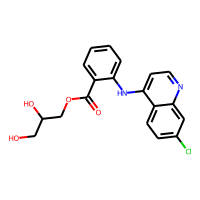
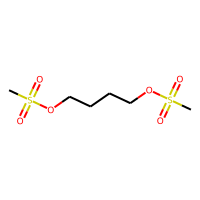
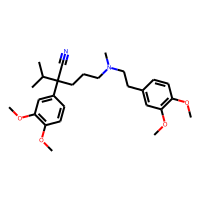
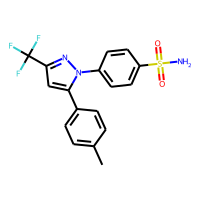
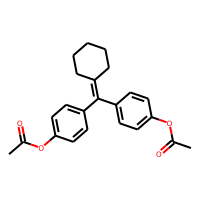

In [68]:
training_df.head()

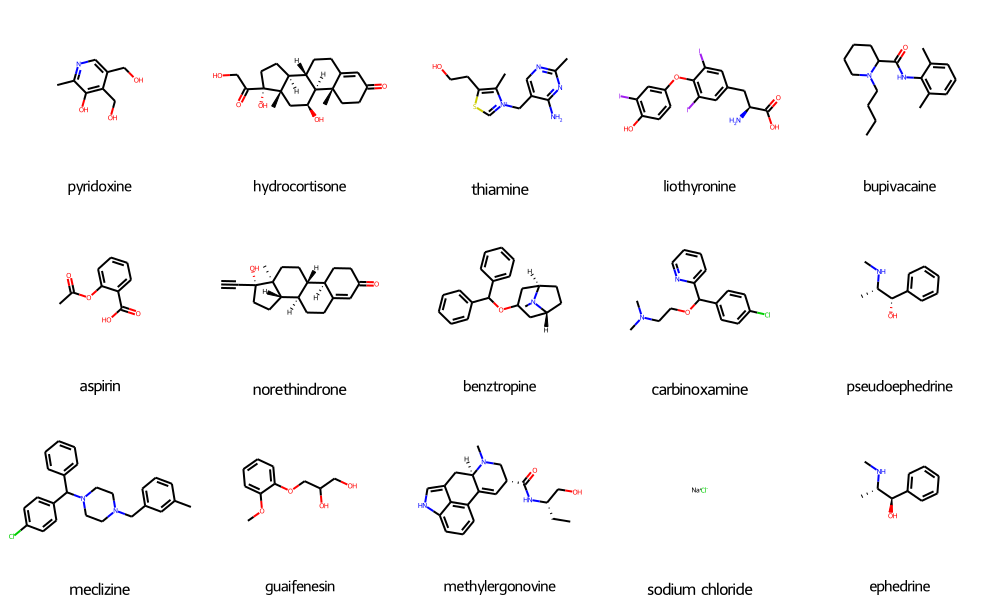

In [71]:
Draw.MolsToGridImage(training_df.ROMol[110:125].to_list(), molsPerRow=5, 
                   legends=training_df.CompoundName[110:125].to_list()) 

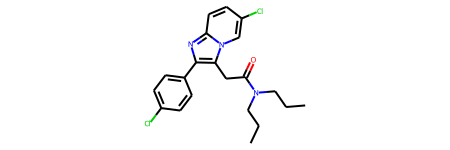

In [72]:
training_df.ROMol[376]

In [73]:
fingerprints = pd.DataFrame(training_df.Fingerprint.to_list())

In [74]:
training_df.columns

Index(['PubChem', 'CompoundName', 'Drug label-based annotation',
       'PubChem_name', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'Smiles', 'inchikey', 'iupacname', 'meshheadings', 'annothits',
       'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation', 'DILI_label', 'PubChem_label', 'ROMol', 'Fingerprint'],
      dtype='object')

In [75]:
mol_properties = training_df[['mw', 'polararea', 'complexity', 'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds']]

In [76]:
features = fingerprints
#features = mol_properties
#features = pd.concat([fingerprints, mol_properties, axis=1)

In [77]:
features.columns

RangeIndex(start=0, stop=2048, step=1)

In [78]:
features.isna().sum().sum()

0

In [79]:
# features.fillna(features.median(), inplace=True)

In [80]:
features.isna().any().value_counts()

False    2048
dtype: int64

In [81]:
labels = training_df.DILI_label

In [82]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=10, test_size=0.2, shuffle=True)

In [83]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (301, 2048) (301,)
Testing set shape:  (76, 2048) (76,)


In [84]:
# Random Forest Classifier

rf_fp = RandomForestClassifier(n_estimators=100, random_state=42)

In [85]:
rf_fp.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [86]:
predicted_rf_fp = rf_fp.predict(X_test)

In [87]:
print(ConfusionMatrix(y_test.ravel(), predicted_rf_fp))

Predict  0        1        
Actual
0        30       12       

1        9        25       





Overall Statistics : 

95% CI                                                            (0.62315,0.82422)
ACC Macro                                                         0.72368
ARI                                                               0.18945
AUNP                                                              0.72479
AUNU                                                              0.72479
Bangdiwala B                                                      0.52659
Bennett S                                                         0.44737
CBA                                                               0.69498
CSI                                                               0.44724
Chi-Squared                                                       15.20159
Chi-Squared DF                                                    1
Conditional Entropy                                          

In [88]:
pd.DataFrame(rf_fp.feature_importances_, index=features.columns).sort_values(0, ascending=False).head(10)

,0
981,0.011467
1380,0.010855
4,0.008148
1385,0.008049
1357,0.007290
1647,0.006705
650,0.006512
1928,0.006273
1457,0.005984
1160,0.005958


In [89]:
# SVM classifier

svm_fp = SVC()

In [90]:
svm_fp.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [91]:
predicted_svm_fp = svm_fp.predict(X_test)

In [92]:
print(ConfusionMatrix(y_test.ravel(), predicted_svm_fp))

Predict  0        1        
Actual
0        25       17       

1        12       22       





Overall Statistics : 

95% CI                                                            (0.50921,0.72764)
ACC Macro                                                         0.61842
ARI                                                               0.04348
AUNP                                                              0.62115
AUNU                                                              0.62115
Bangdiwala B                                                      0.38507
Bennett S                                                         0.23684
CBA                                                               0.57967
CSI                                                               0.24104
Chi-Squared                                                       4.41541
Chi-Squared DF                                                    1
Conditional Entropy                                           

In [93]:
# KNN classifier

knn_fp = KNeighborsClassifier()

In [94]:
knn_fp.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [95]:
predicted_knn_fp = knn_fp.predict(X_test)

In [96]:
print(ConfusionMatrix(y_test.ravel(), predicted_knn_fp))

Predict  0        1        
Actual
0        41       1        

1        26       8        





Overall Statistics : 

95% CI                                                            (0.53714,0.75234)
ACC Macro                                                         0.64474
ARI                                                               0.07271
AUNP                                                              0.60574
AUNU                                                              0.60574
Bangdiwala B                                                      0.55929
Bennett S                                                         0.28947
CBA                                                               0.42362
CSI                                                               0.35616
Chi-Squared                                                       8.04974
Chi-Squared DF                                                    1
Conditional Entropy                                           

### Physico-chemical properties (generated by PaDEL) as ML Features

In [97]:
# padeldescriptor(mol_dir='Output/DILI_labeled.smi', d_file='Output/DILI_descriptors.csv', d_2d=True, d_3d=True, maxruntime=10000, removesalt=True)

In [98]:
DILI_p = pd.read_csv('Output/DILI_descriptors.csv').rename(columns={'Name':'PubChem_label'})
DILI_p

,PubChem_label,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,2478_1,0.0,-1.1338,1.285502,46.6246,30.507102,0,0,28,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3474_1,0.0,-0.3892,0.151477,106.5060,52.363481,0,0,43,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2520_1,0.0,0.8277,0.685087,139.3802,78.266134,0,0,71,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2662_1,0.0,2.1475,4.611756,100.2774,48.730102,0,0,40,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3308_1,1.0,-0.3362,0.113030,83.5849,47.428653,0,0,42,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,11033_1,0.0,-1.2930,1.671849,52.4175,26.927137,0,0,23,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,71467_1,0.0,-0.2009,0.040361,54.4955,28.177102,0,0,26,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,6179_1,0.0,0.1928,0.037172,47.6164,24.281516,0,0,22,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,54897_1,0.0,0.3005,0.090300,115.6802,60.758239,0,0,50,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
DILI_p = DILI_p.dropna(axis=1, how='all')

In [100]:
# replacing Infinity with Nan
DILI_p = DILI_p.replace([np.inf, -np.inf, 'Infinity', '=-Infinity', '#NAME\?'], np.nan, regex=True)

In [101]:
DILI_p.isin([np.inf, -np.inf, 'Infinity', '=-Infinity', '#NAME\?']).sum().sum()

0

In [102]:
# check for missing values
DILI_p.isna().sum().sum()

114187

In [103]:
# replacing missing values with numeric column Median (or '.' for non-numeric)
DILI_p = DILI_p.apply(lambda a: a.fillna(a.median()) if a.dtype.kind in 'biufc' else a.fillna('.'))

In [104]:
DILI_p.isna().values.any()

False

In [105]:
DILI_p.shape

(377, 1735)

In [106]:
# Add PaDEL descriptors to main dataframe
# DILI_training_df = training_df.merge(DILI_p, on='PubChem_label', how='inner')

In [107]:
DILI_p[['PubChem', 'label']] = DILI_p.PubChem_label.str.split('_', expand=True)

In [108]:
DILI_p.columns

Index(['PubChem_label', 'nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol',
       'naAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom',
       ...
       'RDF120s', 'RDF125s', 'RDF130s', 'RDF135s', 'RDF140s', 'RDF145s',
       'RDF150s', 'RDF155s', 'PubChem', 'label'],
      dtype='object', length=1737)

In [109]:
DILI_p.iloc[:, 1:1735].columns

Index(['nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond',
       'nAtom', 'nHeavyAtom', 'nH',
       ...
       'RDF110s', 'RDF115s', 'RDF120s', 'RDF125s', 'RDF130s', 'RDF135s',
       'RDF140s', 'RDF145s', 'RDF150s', 'RDF155s'],
      dtype='object', length=1734)

In [110]:
scaler = MinMaxScaler()
padel_descriptors = scaler.fit_transform(DILI_p.iloc[:, 1:1735])
padel_descriptors

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([[1.66666667e-01, 9.09198089e-01, 3.11736684e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.66666667e-01, 9.19930010e-01, 3.67308882e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.66666667e-01, 9.37469192e-01, 1.66133607e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.66666667e-01, 9.28318377e-01, 9.01151665e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.66666667e-01, 9.29870658e-01, 2.18953687e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.66666667e-01, 9.06995783e-01, 4.01423666e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [111]:
padel_labels = DILI_p.iloc[:, 1736]
padel_labels

0      1
1      1
2      1
3      1
4      1
      ..
372    1
373    1
374    1
375    1
376    1
Name: label, Length: 377, dtype: object

In [112]:
X_train, X_test, y_train, y_test = train_test_split(padel_descriptors, padel_labels, random_state=10, test_size=0.2, shuffle=True)

print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (301, 1734) (301,)
Testing set shape:  (76, 1734) (76,)


In [113]:
# Random Forest Classifier on PaDEL descriptors

rf_padel = RandomForestClassifier(n_estimators=100, random_state=42)
rf_padel.fit(X_train, y_train)
predicted_rf_padel = rf_padel.predict(X_test)
print(ConfusionMatrix(y_test.ravel(), predicted_rf_padel))

Predict  0        1        
Actual
0        32       10       

1        10       24       





Overall Statistics : 

95% CI                                                            (0.63784,0.83584)
ACC Macro                                                         0.73684
ARI                                                               0.21403
AUNP                                                              0.73389
AUNU                                                              0.73389
Bangdiwala B                                                      0.54795
Bennett S                                                         0.47368
CBA                                                               0.73389
CSI                                                               0.46779
Chi-Squared                                                       16.63068
Chi-Squared DF                                                    1
Conditional Entropy                                          

In [114]:
pd.DataFrame(rf_padel.feature_importances_, index=DILI_p.iloc[:, 1:1735].columns).sort_values(0, ascending=False).head(10)

,0
ETA_EtaP_F_L,0.007336
ETA_BetaP,0.006484
Mv,0.006259
HybRatio,0.006016
minHBd,0.005981
MIC1,0.005937
maxHother,0.005775
GATS1v,0.005390
ETA_dEpsilon_B,0.005260
maxHdsCH,0.005196


In [115]:
# SVM classifier on paDEL descriptors

svm_padel = SVC()
svm_padel.fit(X_train, y_train)
predicted_svm_padel = svm_padel.predict(X_test)
print(ConfusionMatrix(y_test.ravel(), predicted_svm_padel))

Predict  0        1        
Actual
0        32       10       

1        10       24       





Overall Statistics : 

95% CI                                                            (0.63784,0.83584)
ACC Macro                                                         0.73684
ARI                                                               0.21403
AUNP                                                              0.73389
AUNU                                                              0.73389
Bangdiwala B                                                      0.54795
Bennett S                                                         0.47368
CBA                                                               0.73389
CSI                                                               0.46779
Chi-Squared                                                       16.63068
Chi-Squared DF                                                    1
Conditional Entropy                                          

In [116]:
# KNN classifier on paDEL descriptors

knn_padel = KNeighborsClassifier()
knn_padel.fit(X_train, y_train)
predicted_knn_padel = knn_padel.predict(X_test)
print(ConfusionMatrix(y_test.ravel(), predicted_knn_padel))

Predict  0        1        
Actual
0        31       11       

1        11       23       





Overall Statistics : 

95% CI                                                            (0.60856,0.81249)
ACC Macro                                                         0.71053
ARI                                                               0.16631
AUNP                                                              0.70728
AUNU                                                              0.70728
Bangdiwala B                                                      0.51027
Bennett S                                                         0.42105
CBA                                                               0.70728
CSI                                                               0.41457
Chi-Squared                                                       13.06173
Chi-Squared DF                                                    1
Conditional Entropy                                          

## Validation on External dataset

### Prepatarion of ML features for validation (Fingerprints)

In [123]:
validation_df = pd.read_csv('Input/validation_greene.csv')
validation_df.head()

,Pubchem,CompoundName,Greene et al.annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label
0,4754.0,phenacetin,HH,0,Phenacetin,phenacetin|N-(4-Ethoxyphenyl)acetamide|62-44-2...,179.22,C10H13NO2,38.3,162.0,...,N-(4-ethoxyphenyl)acetamide,Phenacetin,Biological Test Results|Biomolecular Interacti...,13.0,155|157|161|165|167|175|248|357|377|410|411|42...,20040916.0,3B Scientific (Wuhan) Corp|3WAY PHARM INC|A&J ...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
1,5870.0,estrone,HH,1,Estrone,estrone|53-16-7|folliculin|OESTRONE|Theelin|fo...,270.40,C18H22O2,37.3,418.0,...,"(8R,9S,13S,14S)-3-hydroxy-13-methyl-7,8,9,11,1...",Estrone,Biological Test Results|Biomolecular Interacti...,13.0,357|361|364|368|371|373|374|375|411|422|425|42...,20040916.0,"3WAY PHARM INC|A&J Pharmtech CO., LTD.|A2B Che...",Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1
2,2406.0,bithionol,HH,0,Bithionol,"bithionol|97-18-7|2,2'-Thiobis(4,6-dichlorophe...",356.00,C12H6Cl4O2S,65.8,282.0,...,"2,4-dichloro-6-(3,5-dichloro-2-hydroxyphenyl)s...",Bithionol,Biological Test Results|Biomolecular Interacti...,13.0,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20050325.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
3,3598.0,hexachlorophene,HH,0,Hexachlorophene,hexachlorophene|70-30-4|Hexachlorofen|Hexachlo...,406.90,C13H6Cl6O2,40.5,328.0,...,"3,4,6-trichloro-2-[(2,3,5-trichloro-6-hydroxyp...",Hexachlorophene,Agrochemical Information|Biological Test Resul...,15.0,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20050325.0,"001Chemical|A&J Pharmtech CO., LTD.|A2B Chem|A...",Chemical Vendors|Curation Efforts|Governmental...,NaN,1
4,8667.0,methapyrilene,HH,0,Methapyrilene hydrochloride,METHAPYRILENE HYDROCHLORIDE|135-23-9|Methapyri...,297.80,C14H20ClN3S,47.6,235.0,...,"N,N-dimethyl-N'-pyridin-2-yl-N'-(thiophen-2-yl...",NaN,Biological Test Results|Biomolecular Interacti...,10.0,377|422|429|436|485|547|631|694|731|732|757|75...,20050808.0,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1


In [124]:
validation_df.dtypes

Pubchem                    float64
CompoundName                object
Greene et al.annotation     object
QSAR Prediction              int64
PubChem_name                object
cmpdsynonym                 object
mw                         float64
mf                          object
polararea                  float64
complexity                 float64
xlogp                      float64
heavycnt                   float64
hbonddonor                 float64
hbondacc                   float64
rotbonds                   float64
inchi                       object
Smiles                      object
inchikey                    object
iupacname                   object
meshheadings                object
annothits                   object
annothitcnt                float64
aids                        object
cidcdate                   float64
sidsrcname                  object
depcatg                     object
annotation                  object
DILI_label                   int64
dtype: object

In [125]:
validation_df['Fingerprint'] = validation_df.Smiles.map(fp_bit)
validation_df

,Pubchem,CompoundName,Greene et al.annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label,Fingerprint
0,4754.0,phenacetin,HH,0,Phenacetin,phenacetin|N-(4-Ethoxyphenyl)acetamide|62-44-2...,179.22,C10H13NO2,38.3,162.0,...,Phenacetin,Biological Test Results|Biomolecular Interacti...,13.0,155|157|161|165|167|175|248|357|377|410|411|42...,20040916.0,3B Scientific (Wuhan) Corp|3WAY PHARM INC|A&J ...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5870.0,estrone,HH,1,Estrone,estrone|53-16-7|folliculin|OESTRONE|Theelin|fo...,270.40,C18H22O2,37.3,418.0,...,Estrone,Biological Test Results|Biomolecular Interacti...,13.0,357|361|364|368|371|373|374|375|411|422|425|42...,20040916.0,"3WAY PHARM INC|A&J Pharmtech CO., LTD.|A2B Che...",Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,2406.0,bithionol,HH,0,Bithionol,"bithionol|97-18-7|2,2'-Thiobis(4,6-dichlorophe...",356.00,C12H6Cl4O2S,65.8,282.0,...,Bithionol,Biological Test Results|Biomolecular Interacti...,13.0,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20050325.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3598.0,hexachlorophene,HH,0,Hexachlorophene,hexachlorophene|70-30-4|Hexachlorofen|Hexachlo...,406.90,C13H6Cl6O2,40.5,328.0,...,Hexachlorophene,Agrochemical Information|Biological Test Resul...,15.0,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20050325.0,"001Chemical|A&J Pharmtech CO., LTD.|A2B Chem|A...",Chemical Vendors|Curation Efforts|Governmental...,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,8667.0,methapyrilene,HH,0,Methapyrilene hydrochloride,METHAPYRILENE HYDROCHLORIDE|135-23-9|Methapyri...,297.80,C14H20ClN3S,47.6,235.0,...,NaN,Biological Test Results|Biomolecular Interacti...,10.0,377|422|429|436|485|547|631|694|731|732|757|75...,20050808.0,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,447458.0,ragaglitazar,NE,1,Ragaglitazar,Ragaglitazar|(2S)-2-ETHOXY-3-{4-[2-(10H-PHENOX...,419.50,C25H25NO5,68.2,542.0,...,NaN,Biological Test Results|Biomolecular Interacti...,6.0,1811|25979|25980|27154|27155|27882|28334|28335...,20050624.0,AbaChemScene|ABI Chem|Achemtek|BindingDB|Chemb...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
229,16682734.0,bismuth subsalicylate,NE,1,Bismuth subsalicylate,BISMUTH SUBSALICYLATE|14882-18-9|Bismuth oxysa...,363.10,C7H6BiO4,36.5,173.0,...,NaN,Biological Test Results|Biomolecular Interacti...,12.0,568|583|598|602|606|618|620|629|630|633|639|64...,20070823.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
230,54677972.0,isoxicam,NE,1,Isoxicam,isoxicam|34552-84-6|Maxicam|Isoxicamo|Isoxicam...,335.34,C14H13N3O5S,121.0,627.0,...,NaN,Biological Test Results|Biomolecular Interacti...,10.0,357|361|364|368|371|373|374|375|410|411|422|42...,20111226.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
231,892.0,inositol,NE,0,Inositol,inositol|myo-inositol|Scyllo-inositol|Muco-Ino...,180.16,C6H12O6,121.0,104.0,...,NaN,Biological Test Results|Biomolecular Interacti...,13.0,1|3|5|7|9|13|19|23|25|29|31|33|35|37|39|41|43|...,20040916.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-vi

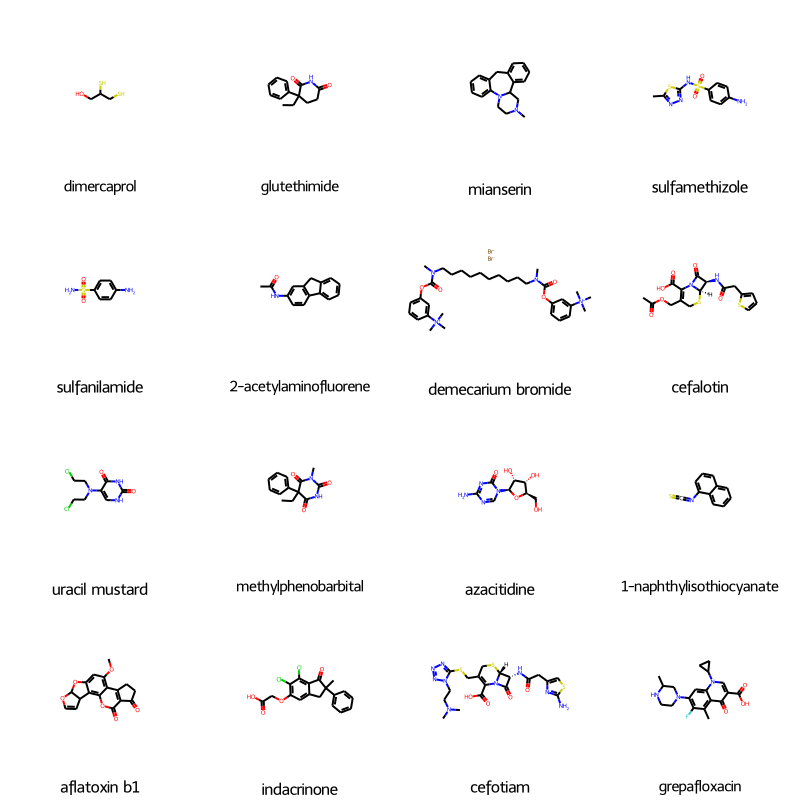

In [131]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in validation_df.Smiles[110:126] \
                      if smile is not None], molsPerRow=4, 
                      legends=validation_df.CompoundName[110:126].to_list()) 

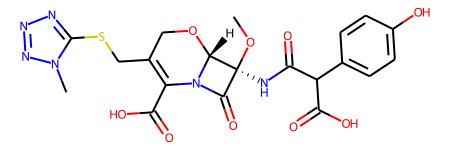

In [132]:
Chem.MolFromSmiles(validation_df.Smiles[232])

In [133]:
validation_features = pd.DataFrame(validation_df.Fingerprint.to_list())
validation_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
validation_features.isna().sum().sum()

0

In [135]:
validation_labels = validation_df.DILI_label
validation_labels

0      1
1      1
2      1
3      1
4      1
      ..
228    0
229    0
230    0
231    0
232    0
Name: DILI_label, Length: 233, dtype: int64

In [136]:
training_features = pd.DataFrame(training_df.Fingerprint.to_list())
training_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
training_features.isna().sum().sum()

0

In [138]:
training_labels = training_df.DILI_label
training_labels

0      1
1      1
2      1
3      1
4      1
      ..
372    1
373    1
374    1
375    1
376    1
Name: DILI_label, Length: 377, dtype: int64

In [139]:
rf_fp.fit(training_features, training_labels)
predicted_validation_rf_fp = rf_fp.predict(validation_features)
print(ConfusionMatrix(validation_labels.ravel(), predicted_validation_rf_fp))

Predict  0        1        
Actual
0        62       22       

1        83       66       





Overall Statistics : 

95% CI                                                            (0.48547,0.61324)
ACC Macro                                                         0.54936
ARI                                                               0.00136
AUNP                                                              0.59052
AUNU                                                              0.59052
Bangdiwala B                                                      0.32421
Bennett S                                                         0.09871
CBA                                                               0.43527
CSI                                                               0.17932
Chi-Squared                                                       7.49134
Chi-Squared DF                                                    1
Conditional Entropy                                           

In [140]:
svm_fp.fit(training_features, training_labels)
predicted_validation_svm_fp = svm_fp.predict(validation_features)
print(ConfusionMatrix(validation_labels.ravel(), predicted_validation_svm_fp))

Predict  0        1        
Actual
0        61       23       

1        82       67       





Overall Statistics : 

95% CI                                                            (0.48547,0.61324)
ACC Macro                                                         0.54936
ARI                                                               0.00196
AUNP                                                              0.58793
AUNU                                                              0.58793
Bangdiwala B                                                      0.32295
Bennett S                                                         0.09871
CBA                                                               0.43812
CSI                                                               0.17344
Chi-Squared                                                       7.00732
Chi-Squared DF                                                    1
Conditional Entropy                                           